In [1]:
import pandas as pd
import numpy as np

import requests

from time import sleep 

import tqdm
import re 

from typing import Dict, List 

from random import randint

In [43]:
category_main_cb = 4 # 1=byty, 2=domy, 3=pozemky, 4=komerční, 5=ostatní
category_type_cb = 1 # 1=prodej, 2=nájem, 3=dražba
locality_region_id = 10 #10=Prague

category_main_cb_dict={1:"flat", 2:"domy", 3:"pozemky", 4:"komerční", 5:"ostatní"}
category_main_cb_dict=pd.DataFrame.from_dict(category_main_cb_dict, orient="index", columns=["category_main_cb"])
print(category_main_cb_dict)

category_type_cb_dict={1:"prodej", 2:"nájem", 3:"dražba"}
category_type_cb_dict=pd.DataFrame.from_dict(category_type_cb_dict, orient="index", columns=["category_type_cb"])
print(category_type_cb_dict)

  category_main_cb
1             flat
2             domy
3          pozemky
4         komerční
5          ostatní
  category_type_cb
1           prodej
2            nájem
3           dražba


In [3]:
collector={}
i=0
run=True

while run==True:
    base_url = 'https://www.sreality.cz/api/cs/v2/estates?category_main_cb={}&category_type_cb={}&locality_region_id={}&per_page60&page={}'.format(category_main_cb, category_type_cb, locality_region_id, i)

    r = requests.get(base_url)
    print("starting sleep")
    sleep(randint(1,3))

    if r.status_code==404:
        break
    elif r.status_code==200:
        r_dict=r.json()

        if len(r_dict["_embedded"]["estates"]) == 0:
            print(f"Page {i+1} is blank.")
            break

        collector[i]=r_dict
        
        print(f"Page {i+1} was scraped.")

        i=i+1
        j=0

    else:
        if  j==3:
            print(f"Code {r.status_code} was returned.")
            break
        else:
            j=j+1

starting sleep
Page 1 was scraped.
starting sleep
Page 2 was scraped.
starting sleep
Page 3 was scraped.
starting sleep
Page 4 was scraped.
starting sleep
Page 5 was scraped.
starting sleep
Page 6 was scraped.
starting sleep
Page 7 was scraped.
starting sleep
Page 8 was scraped.
starting sleep
Page 9 was scraped.
starting sleep
Page 10 was scraped.
starting sleep
Page 11 was scraped.
starting sleep
Page 12 was scraped.
starting sleep
Page 13 was scraped.
starting sleep
Page 14 was scraped.
starting sleep
Page 15 was scraped.
starting sleep
Page 16 was scraped.
starting sleep
Page 17 was scraped.
starting sleep
Page 18 was scraped.
starting sleep
Page 19 was scraped.
starting sleep
Page 20 was scraped.
starting sleep
Page 21 was scraped.
starting sleep
Page 22 was scraped.
starting sleep
Page 23 was scraped.
starting sleep
Page 24 was scraped.
starting sleep
Page 25 was scraped.
starting sleep
Page 26 was scraped.
starting sleep
Page 27 was scraped.
starting sleep
Page 28 is blank.


In [5]:
def get_gps_lat_lon(estate_raw: Dict):
    gps_ = estate_raw['gps']
    return gps_['lat'], gps_['lon']

# more robust implementation using regex - https://docs.python.org/3/library/re.html
def get_area_from_name(name: str):
    """(\d*) matches any decimal digits (repeated after each other"""
    name_ = name.split()
    return int(''.join(re.findall('(\d*)', ''.join(name_))))


In [45]:
collector[0];

In [44]:
collector[0]['_embedded']["estates"][0].keys();

In [9]:
# slow helper functions (use itertools.chains for speedup)
def flatten_list(l:List):
    return [item for sublist in l for item in sublist]

def get_distinct_nearby_objects(estates_individual_raw: Dict):
    lists_of_nearby_objects = [e['labelsAll'][1] for e in estates_individual_raw.values()]
    return list(set(flatten_list(lists_of_nearby_objects)))

def get_distinct_estate_attributes(estates_individual_raw: Dict):
    lists_of_estates_attributes = [e['labelsAll'][0] for e in estates_individual_raw.values()]
    return list(set(flatten_list(lists_of_estates_attributes)))

In [18]:
raw_attributes_to_collect = ['locality', 'price', 'name', 'gps','hash_id','labelsAll','exclusively_at_rk']

estates_individual_raw = {}
estates_individual = {}

for page, r in collector.items():
    for estate in r['_embedded']['estates']: 

        estate_raw = {k:v for k,v in estate.items() if k in raw_attributes_to_collect}

        estate_relevant = pd.Series(dtype="object")

        estate_relevant['price'] = int(estate['price'])
        estate_relevant['price_czk'] = int(estate['price_czk']["value_raw"])
        estate_relevant['area'] = get_area_from_name(estate['name'])

        lat, lon = get_gps_lat_lon(estate)
        estate_relevant.loc['lat'] = lat
        estate_relevant.loc['lon'] = lon
        estate_relevant['locality'] = estate['locality']
        estate_relevant['type'] = estate['type']
        estate_relevant['category'] = estate['category']

        estate_relevant['category_main_cb'] = estate["seo"]["category_main_cb"]
        estate_relevant['category_sub_cb'] = estate["seo"]["category_sub_cb"]
        estate_relevant['category_type_cb'] = estate["seo"]["category_type_cb"]
        
        estates_individual_raw[estate['hash_id']] = estate_raw
        estates_individual[estate['hash_id']] = estate_relevant

In [19]:
get_distinct_nearby_objects(estates_individual_raw);
get_distinct_estate_attributes(estates_individual_raw);

In [20]:
estates_individual

{327632988: price                          8620000.0
 area                               209.0
 gps_lat                        50.095701
 gps_lon                        14.464636
 locality            Praha 7 - Holešovice
 category_main_cb                       4
 category_sub_cb                       28
 category_type_cb                       1
 dtype: object,
 2266027852: price                          6340000.0
 area                               124.0
 gps_lat                        50.095701
 gps_lon                        14.464636
 locality            Praha 7 - Holešovice
 category_main_cb                       4
 category_sub_cb                       28
 category_type_cb                       1
 dtype: object,
 3789608780: price                          2235000.0
 area                                85.0
 gps_lat                        50.095701
 gps_lon                        14.464636
 locality            Praha 7 - Holešovice
 category_main_cb                       4
 category

In [21]:
df = pd.concat(estates_individual).unstack()

In [22]:
df.head()

,price,area,gps_lat,gps_lon,locality,category_main_cb,category_sub_cb,category_type_cb
327632988,8620000.0,209.0,50.095701,14.464636,Praha 7 - Holešovice,4,28,1
2266027852,6340000.0,124.0,50.095701,14.464636,Praha 7 - Holešovice,4,28,1
3789608780,2235000.0,85.0,50.095701,14.464636,Praha 7 - Holešovice,4,26,1
714983244,10730000.0,77.0,50.041765,14.467507,Praha 4,4,28,1
2986792780,57541000.0,703.0,50.061811,14.456352,Praha 10 - Vršovice,4,38,1


In [15]:
df.shape

(505, 8)

In [16]:
#df.to_parquet('df.gzip')  

# Collecting description of offers

In [17]:
df=pd.read_parquet('df.gzip')

FileNotFoundError: [Errno 2] No such file or directory: 'df.gzip'

In [ ]:
df.index

Int64Index([ 278969436, 2820425292, 3573004380, 1050925916, 3448788556,
            1599563340, 1697921372, 3478633564, 4004559964, 4128713820,
            ...
             767428956,  961203036, 2088259932,  330033500, 4110512476,
            3619029596, 1780482396, 1430389084, 3159732572, 4065702236],
           dtype='int64', length=4320)

In [ ]:
df_desc_read=pd.read_parquet('df_desc.gzip')

In [ ]:
df_desc_read.index

Int64Index([ 278969436, 2820425292, 3573004380, 1050925916, 3448788556,
            1599563340, 1697921372, 3478633564, 4004559964, 4128713820,
            ...
            1141119836, 2033458012,  111741788, 2629068364, 3597814108,
            3343001420, 3866937164, 3814696012, 2195949388, 3934954572],
           dtype='int64', length=1448)

In [ ]:
desc_indices=df.index[~df.index.isin(df_desc_read.index)]
desc_indices

Int64Index([3086218828, 1412695884,  943256652, 3119510604, 2951738444,
            3785798732, 2855449676,  871363660, 3188716620, 1061155916,
            1861152348, 3983529548, 4249662540, 4257805388,  199816268,
             907605068,  841544780, 3394827340, 3667522636, 2324296780,
             210367564, 1419441228, 1093203020, 3072914508, 1881863244,
            1394115660, 1011323980, 3302200396],
           dtype='int64')

In [ ]:
desc_indices.drop_duplicates()
desc_indices.shape

In [ ]:
collector_description={}

for i in range(len(desc_indices)):
    base_url = 'https://www.sreality.cz/api/cs/v2/estates/{}'.format(desc_indices[i])

    r = requests.get(base_url)

    #print("starting sleep")
    #sleep(randint(0,2))

    if r.status_code==404:
        break
    
    elif r.status_code==200:
        r_dict=r.json()
        r_dict["hash_id"]=desc_indices[i]

        collector_description[i]=r_dict
        
        print(f"Description {i} was scraped.")

Description 2 was scraped.
Description 3 was scraped.
Description 4 was scraped.
Description 5 was scraped.
Description 6 was scraped.
Description 7 was scraped.
Description 8 was scraped.
Description 9 was scraped.
Description 10 was scraped.
Description 11 was scraped.
Description 12 was scraped.
Description 13 was scraped.
Description 14 was scraped.
Description 15 was scraped.
Description 16 was scraped.
Description 17 was scraped.
Description 18 was scraped.
Description 19 was scraped.
Description 20 was scraped.
Description 21 was scraped.
Description 22 was scraped.
Description 23 was scraped.
Description 24 was scraped.
Description 25 was scraped.
Description 26 was scraped.
Description 27 was scraped.
Description 28 was scraped.
Description 29 was scraped.
Description 30 was scraped.
Description 31 was scraped.
Description 32 was scraped.
Description 33 was scraped.
Description 34 was scraped.
Description 35 was scraped.
Description 36 was scraped.
Description 37 was scraped.


In [ ]:
description_individual = {}

for page, r_dict in collector_description.items():
        
        info_relevant = pd.Series(dtype="object")
        info_relevant["description"]=r_dict["text"]["value"]

        r_dict_values=pd.DataFrame(r_dict["items"], columns =['type', 'name', 'value'])

        info_relevant["price"]=r_dict_values["value"][r_dict_values["name"]=="Cena"]
        info_relevant["price_note"]=r_dict_values["value"][r_dict_values["name"]=="Poznámka k ceně"]
        info_relevant["price_per_sqm"]=r_dict_values["value"][r_dict_values["name"]=="Cena za m²"]
        info_relevant["id_order"]=r_dict_values["value"][r_dict_values["name"]=="ID zakázky"]
        info_relevant["date_update"]=r_dict_values["value"][r_dict_values["name"]=="Aktualizace"]
        info_relevant["building_type"]=r_dict_values["value"][r_dict_values["name"]=="Stavba"]
        info_relevant["availability"]=r_dict_values["value"][r_dict_values["name"]=="Stav"]
        info_relevant["building_condition"]=r_dict_values["value"][r_dict_values["name"]=="Stav objektu"]
        info_relevant["building_location"]=r_dict_values["value"][r_dict_values["name"]=="Umístění objektu"]
        info_relevant["building_floor_type"]=r_dict_values["value"][r_dict_values["name"]=="Typ domu"]
        info_relevant["building_floor"]=r_dict_values["value"][r_dict_values["name"]=="Podlaží"]
        info_relevant["date_moving_in"]=r_dict_values["value"][r_dict_values["name"]=="Datum nastěhování"]
        info_relevant["area_build_up"]=r_dict_values["value"][r_dict_values["name"]=="Plocha zastavěná"]
        info_relevant["garage"]=r_dict_values["value"][r_dict_values["name"]=="Garáž"]
        info_relevant["parking"]=r_dict_values["value"][r_dict_values["name"]=="Parkování"]

        if sum(r_dict_values['name'] == "Voda")>0:
                index_nr=int(r_dict_values.index[r_dict_values['name'] == "Voda"].tolist()[0])
                r_dict_values["value"][r_dict_values["name"]=="Voda"][index_nr][0]["value"]
                del index_nr

        if sum(r_dict_values['name'] == "Topení")>0:
                index_nr=int(r_dict_values.index[r_dict_values['name'] == "Topení"].tolist()[0])
                r_dict_values["value"][r_dict_values["name"]=="Topení"][index_nr][0]["value"]
                del index_nr

        if sum(r_dict_values['name'] == "Doprava")>0:
                index_nr=int(r_dict_values.index[r_dict_values['name'] == "Doprava"].tolist()[0])
                r_dict_values["value"][r_dict_values["name"]=="Doprava"][index_nr][0]["value"]
                del index_nr

        if sum(r_dict_values['name'] == "Telekomunikace")>0:
                index_nr=int(r_dict_values.index[r_dict_values['name'] == "Telekomunikace"].tolist()[0])
                r_dict_values["value"][r_dict_values["name"]=="Telekomunikace"][index_nr][0]["value"]
                del index_nr

        if sum(r_dict_values['name'] == "Plyn")>0:
                index_nr=int(r_dict_values.index[r_dict_values['name'] == "Plyn"].tolist()[0])
                r_dict_values["value"][r_dict_values["name"]=="Plyn"][index_nr][0]["value"]
                del index_nr

        info_relevant["energy_efficient_rating"]=r_dict_values["value"][r_dict_values["name"]=="Energetická náročnost budovy"]
        info_relevant["lift"]=r_dict_values["value"][r_dict_values["name"]=="Výtah"]
        info_relevant["equipped"]=r_dict_values["value"][r_dict_values["name"]=="Vybavení"]

        description_individual[r_dict["hash_id"]] = info_relevant

In [ ]:
r_dict_values

,type,name,value
0,price_czk,Celková cena,5 000
1,price,Cena za m²,833
2,string,ID zakázky,CZvo747
3,edited,Aktualizace,12.09.2022
4,string,Stavba,Smíšená
5,string,Stav objektu,Velmi dobrý
6,string,Typ domu,Patrový
7,area,Užitná plocha,6
8,string,Datum nastěhování,Ihned
9,set,Doprava,"[{'name': 'Doprava', 'value': 'Autobus'}]"


In [ ]:
description_individual[r_dict["hash_id"]] = info_relevant

In [ ]:
df_desc = pd.concat(description_individual).unstack()
df_desc.head()

,description,price,price_note,price_per_sqm,id_order,date_update,building_type,availability,building_condition,building_location,building_floor_type,building_floor,date_moving_in,area_build_up,garage,parking,energy_efficient_rating,lift,equipped
2760549452,Představujeme Vám reprezentativní komerční pro...,"0 Informace o ceně na dotaz Name: value, dt...","Series([], Name: value, dtype: object)","Series([], Name: value, dtype: object)","1 000416 Name: value, dtype: object","2 12.12.2022 Name: value, dtype: object","3 Smíšená Name: value, dtype: object","Series([], Name: value, dtype: object)","4 Velmi dobrý Name: value, dtype: object","Series([], Name: value, dtype: object)","5 Přízemní Name: value, dtype: object","6 1. podlaží Name: value, dtype: object","9 Ihned Name: value, dtype: object","Series([], Name: value, dtype: object)","Series([], Name: value, dtype: object)","8 True Name: value, dtype: object",12 Třída G - Mimořádně nehospodárná č. 78/2...,"13 True Name: value, dtype: object","Series([], Name: value, dtype: object)"
1337631820,Dovoluji si Vám nabídnout možný pronájem 55m2 ...,"Series([], Name: value, dtype: object)","2 1500kč elektřina+provize Name: value, dty...","1 214 Name: value, dtype: object","3 N19334 Name: value, dtype: object","4 05.12.2022 Name: value, dtype: object","5 Cihlová Name: value, dtype: object","Series([], Name: value, dtype: object)","6 Velmi dobrý Name: value, dtype: object","7 Klidná část obce Name: value, dtype: object","8 Patrový Name: value, dtype: object","Series([], Name: value, dtype: object)","11 Ihned Name: value, dtype: object","Series([], Name: value, dtype: object)","Series([], Name: value, dtype: object)","10 True Name: value, dtype: object",16 Třída G - Mimořádně nehospodárná Name: v...,"Series([], Name: value, dtype: object)","17 Částečně Name: value, dtype: object"
3810174028,Nabízíme k pronájmu plně vybavenou fungující p...,"Series([], Name: value, dtype: object)","Series([], Name: value, dtype: object)","1 259 Name: value, dtype: object","2 0257-NP00961 Name: value, dtype: object","3 26.11.2022 Name: value, dtype: object","4 Cihlová Name: value, dtype: object","Series([], Name: value, dtype: object)","5 Velmi dobrý Name: value, dtype: object","Series([], Name: value, dtype: object)","6 Přízemní Name: value, dtype: object","7 1. podlaží z celkem 1 Name: value, dtype:...","10 Ihned Name: value, dtype: object","8 116 Name: value, dtype: object","Series([], Name: value, dtype: object)","Series([], Name: value, dtype: object)",17 Třída E - Nehospodárná č. 78/2013 Sb. po...,"Series([], Name: value, dtype: object)","19 True Name: value, dtype: object"
3710559308,Nabízím Vám možný pronájem prostor 360m2 otevř...,"0 Informace o ceně na dotaz Name: value, dt...",1 +služby+provize ve výši nájmu Name: value...,"Series([], Name: value, dtype: object)","2 N19333 Name: value, dtype: object","3 30.11.2022 Name: value, dtype: object","4 Skeletová Name: value, dtype: object","Series([], Name: value, dtype: object)","5 Velmi dobrý Name: value, dtype: object","Series([], Name: value, dtype: object)","6 Patrový Name: value, dtype: object","Series([], Name: value, dtype: object)","8 Ihned Name: value, dtype: object","Series([], Name: value, dtype: object)","Series([], Name: value, dtype: object)","Series([], Name: value, dtype: object)",14 Třída G - Mimořádně nehospodárná Name: v...,"Series([], Name: value, dtype: object)","Series([], Name: value, dtype: object)"
2371527756,Dovolujeme si Vám nabídnout k pronájmu repreze...,"0 Informace o ceně na dotaz Name: value, dt...",1 + servisní poplatky 138 Kč/m²/měs. ~ Nepl...,"Series([], Name: value, dtype: object)","2 N74828 Name: value, dtype: object","3 26.11.2022 Name: value, dtype: object","4 Montovaná Name: value, dtype: object","Series([], Name: value, dtype: object)","5 Velmi dobrý Name: value, dtype: object","6 Rušná část obce Name: value, dtype: object","7 Patrový Name: value, dtype: object","8 3. podlaží Name: value, dtype: object","11 Ihned Na

In [ ]:
df_desc_full = pd.concat([df_desc, df_desc_read])
df_desc_full.to_parquet('df_desc_full.gzip')  
#df_desc.to_parquet('df_desc.gzip')  

In [ ]:
df_desc.head()
df_desc.shape

(2847, 1)

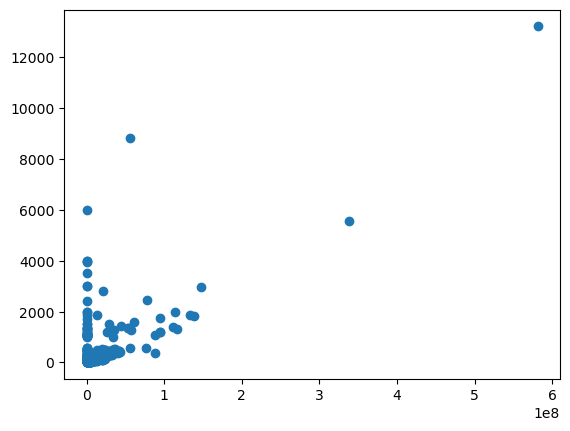

In [ ]:
import matplotlib.pyplot as plt 
df_filtered=df.loc[df['area'] < 100000] 
plt.scatter(df_filtered['price'],df_filtered['area'])

# New version of scraping - proxies and multiple requests at the same time

In [ ]:
from fp.fp import FreeProxy
import gevent
from gevent import monkey, pool
#https://stackoverflow.com/questions/15322701/gevent-pool-with-nested-web-requests
#https://pypi.org/project/free-proxy/

In [ ]:
proxy = FreeProxy(country_id=['DE', "CZ", "BR"]).get()

In [ ]:
urls=np.add("https://www.sreality.cz/api/cs/v2/estates/", desc_indices)

In [ ]:
monkey.patch_all()

jobs = []
links = []
p = pool.Pool(10)

add

urls = [
    'http://www.google.com', 
    # ... another 100 urls
]
    
def get_jsons(url):
    r = requests.get(url)
    if r.status_code == 200:
        r_dict = r.json()
        r_dict["hash_id"]=desc_indices[i]

        collector_description[i]=r_dict
        
for url in urls:
    jobs.append(p.spawn(get_jsons, url))
gevent.joinall(jobs)